анализ ЭЭГ в тензорном представлении. проверка декомпозиции. проверка скрипта для поиска оптимального ранга. проверка типа данных в тензорном представлении.

# Импорты и конфиг

In [1]:
import sys

modules_to_reload = [
    "src.utils.eeg_controller",
]

for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

%load_ext autoreload
%autoreload 2

import gc
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np
import tensorly as tl
import torch

from src.utils.metrics_calculators import IMetricCalculator

mpl.use("Agg")
%matplotlib notebook

In [2]:
torch.cuda.empty_cache()
gc.collect()

4

In [3]:
cache_dir = Path("../.cache/eeg")

# Скачивание части датасета EEG

In [4]:
eeg_raw_list = {}
subjects = list(range(1, 4))  # 110
runs = list(range(3, 15))  # 15

for subject in subjects:
    eeg_raw_list[subject] = {}

for subject in subjects:
    data_path = mne.datasets.eegbci.load_data(subject=subject, runs=runs, path=cache_dir)
    raw_fnames = data_path

    for run_idx, f in enumerate(raw_fnames, start=3):
        raw = mne.io.read_raw_edf(f, preload=True)

        raw.rename_channels(
            {
                ch: ch.replace(".", "").upper().replace("Z", "z").replace("FP1", "Fp1").replace("FP2", "Fp2")
                for ch in raw.ch_names
            }
        )

        eeg_raw_list[subject][run_idx] = raw

Extracting EDF parameters from /home/johndoe_19/git-projects/tensor-methods-comparison/.cache/eeg/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/johndoe_19/git-projects/tensor-methods-comparison/.cache/eeg/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/johndoe_19/git-projects/tensor-methods-comparison/.cache/eeg/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/johndoe_19/git-projects/tensor-methods-comparison/.cache/eeg/MNE-eegbci-data/file

# Корректировка монтажа

In [5]:
montage_biosemi64 = mne.channels.make_standard_montage("biosemi64")

In [6]:
montage_copy = montage_biosemi64.copy()

In [7]:
coordsT9 = np.array([-0.08869014, -0.0, -0.04014873])
coordsT10 = np.array([0.08869014, 0.0, -0.04014873])

In [8]:
def edit_montage_dig(montage, old_name, new_name, new_coords=None):
    if old_name in montage.ch_names:
        idx = montage.ch_names.index(old_name)

        if new_coords is not None:
            montage.dig[idx + 3]["r"] = new_coords
            print(f"Координаты {old_name} изменены на {new_coords}")

        montage.ch_names[idx] = new_name
        print(f"Название электрода {old_name} изменено на {new_name}")
    else:
        print(f"Электрод {old_name} не найден в монтаже")


edit_montage_dig(montage_copy, "P9", "T9", coordsT9)
edit_montage_dig(montage_copy, "P10", "T10", coordsT10)
edit_montage_dig(montage_copy, "Fpz", "FPz")

Координаты P9 изменены на [-0.08869014 -0.         -0.04014873]
Название электрода P9 изменено на T9
Координаты P10 изменены на [ 0.08869014  0.         -0.04014873]
Название электрода P10 изменено на T10
Название электрода Fpz изменено на FPz


In [9]:
update_info = [
    {"name": "Fp1", "order": 22},
    {"name": "FPz", "order": 23},
    {"name": "Fp2", "order": 24},
    {"name": "AF7", "order": 25},
    {"name": "AF3", "order": 26},
    {"name": "AFz", "order": 27},
    {"name": "AF4", "order": 28},
    {"name": "AF8", "order": 29},
    {"name": "F7", "order": 30},
    {"name": "F5", "order": 31},
    {"name": "F3", "order": 32},
    {"name": "F1", "order": 33},
    {"name": "Fz", "order": 34},
    {"name": "F2", "order": 35},
    {"name": "F4", "order": 36},
    {"name": "F6", "order": 37},
    {"name": "F8", "order": 38},
    {"name": "FT7", "order": 39},
    {"name": "FC5", "order": 1},
    {"name": "FC3", "order": 2},
    {"name": "FC1", "order": 3},
    {"name": "FCz", "order": 4},
    {"name": "FC2", "order": 5},
    {"name": "FC4", "order": 6},
    {"name": "FC6", "order": 7},
    {"name": "FT8", "order": 8},
    {"name": "T9", "order": 43},
    {"name": "T7", "order": 41},
    {"name": "C5", "order": 8},
    {"name": "C3", "order": 9},
    {"name": "C1", "order": 10},
    {"name": "Cz", "order": 11},
    {"name": "C2", "order": 12},
    {"name": "C4", "order": 13},
    {"name": "C6", "order": 14},
    {"name": "T8", "order": 42},
    {"name": "T10", "order": 44},
    {"name": "TP7", "order": 45},
    {"name": "CP5", "order": 15},
    {"name": "CP3", "order": 16},
    {"name": "CP1", "order": 17},
    {"name": "CPz", "order": 18},
    {"name": "CP2", "order": 19},
    {"name": "CP4", "order": 20},
    {"name": "CP6", "order": 21},
    {"name": "TP8", "order": 46},
    {"name": "P7", "order": 47},
    {"name": "P5", "order": 48},
    {"name": "P3", "order": 49},
    {"name": "P1", "order": 50},
    {"name": "Pz", "order": 51},
    {"name": "P2", "order": 52},
    {"name": "P4", "order": 53},
    {"name": "P6", "order": 54},
    {"name": "P8", "order": 55},
    {"name": "PO7", "order": 56},
    {"name": "PO3", "order": 57},
    {"name": "POz", "order": 58},
    {"name": "PO4", "order": 59},
    {"name": "PO8", "order": 60},
    {"name": "O1", "order": 61},
    {"name": "Oz", "order": 62},
    {"name": "O2", "order": 63},
    {"name": "Iz", "order": 64},
]

In [10]:
def update_montage_points_with_offset(montage, update_info, offset=3):
    for item in update_info:
        name = item["name"]
        order = item["order"] - 1 + offset

        if order < 0 or order >= len(montage.dig):
            raise IndexError(f"Порядковый номер {order} выходит за пределы dig")

        if name not in montage.ch_names:
            montage.ch_names.append(name)
        else:
            idx = montage.ch_names.index(name)
            montage.ch_names[idx] = name

In [11]:
update_montage_points_with_offset(montage_copy, update_info)

In [12]:
for raw_list_by_runs in eeg_raw_list.values():
    for raw in raw_list_by_runs.values():
        raw.set_montage(montage_copy)

# Анализ данных из датасета

## Анализ аннотаций

In [13]:
annotations = eeg_raw_list[2][3].annotations
for idx, (onset, duration, description) in enumerate(
    zip(
        annotations.onset,
        annotations.duration,
        annotations.description,
        strict=False,
    )
):
    print(f"Annotation {idx + 1}:")
    print(f"  Onset: {onset} s")
    print(f"  Duration: {duration} s")
    print(f"  Description: {description}")
    print()

Annotation 1:
  Onset: 0.0 s
  Duration: 4.1 s
  Description: T0

Annotation 2:
  Onset: 4.1 s
  Duration: 4.1 s
  Description: T1

Annotation 3:
  Onset: 8.2 s
  Duration: 4.1 s
  Description: T0

Annotation 4:
  Onset: 12.3 s
  Duration: 4.1 s
  Description: T2

Annotation 5:
  Onset: 16.4 s
  Duration: 4.1 s
  Description: T0

Annotation 6:
  Onset: 20.5 s
  Duration: 4.1 s
  Description: T2

Annotation 7:
  Onset: 24.6 s
  Duration: 4.1 s
  Description: T0

Annotation 8:
  Onset: 28.7 s
  Duration: 4.1 s
  Description: T1

Annotation 9:
  Onset: 32.8 s
  Duration: 4.1 s
  Description: T0

Annotation 10:
  Onset: 36.9 s
  Duration: 4.1 s
  Description: T1

Annotation 11:
  Onset: 41.0 s
  Duration: 4.1 s
  Description: T0

Annotation 12:
  Onset: 45.1 s
  Duration: 4.1 s
  Description: T2

Annotation 13:
  Onset: 49.2 s
  Duration: 4.1 s
  Description: T0

Annotation 14:
  Onset: 53.3 s
  Duration: 4.1 s
  Description: T2

Annotation 15:
  Onset: 57.4 s
  Duration: 4.1 s
  Descripti

## Анализ воздействия фильтра

In [14]:
events, event_id = mne.events_from_annotations(eeg_raw_list[1][3])
tmin, tmax = 0.0, 4.0
epochs = mne.Epochs(
    eeg_raw_list[1][3],
    events,
    event_id,
    tmin,
    tmax,
    baseline=(0, 0),
    preload=True,
)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped


In [15]:
# Получаем среднее значение по времени для каждой эпохи
data_mean = epochs.get_data().mean(axis=2)  # Среднее по времени (по оси 2)

# Получаем позиции каналов
pos = np.array([ch["loc"][:2] for ch in epochs.info["chs"]])

# Строим топографию для необработанных данных
fig, ax = plt.subplots(figsize=(8, 8))
mne.viz.plot_topomap(
    data_mean.mean(axis=0),  # Среднее по всем эпохам для каждого канала
    pos,  # Позиции каналов
    ch_type="eeg",  # Тип каналов
    names=epochs.ch_names,  # Названия каналов
    sensors=True,  # Отображение датчиков
    cmap="RdBu_r",  # Цветовая карта
    contours=6,  # Количество контуров
    res=256,  # Разрешение
    size=8,  # Размер
    axes=ax,  # Основа для рисования
    show=False,  # Не показывать сразу
)
plt.title("Topography Before Filtering")
plt.show()

<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

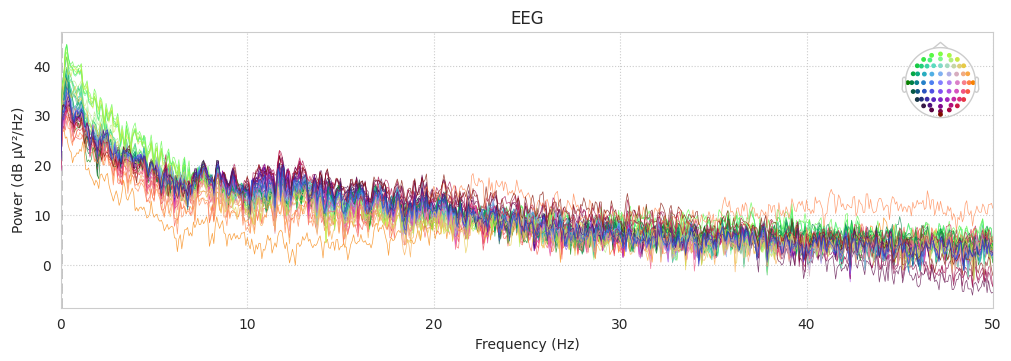

In [16]:
eeg_raw_list[1][3].plot_psd(fmax=50.0)

In [17]:
epochs_filtered = epochs.copy().filter(l_freq=0.5, h_freq=50.0)
eeg_raw_list[1][3].filter(l_freq=0.5, h_freq=50.0)

Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1057 samples (6.606 s)



/tmp/ipykernel_1064/4036423806.py:1: RuntimeWarning: filter_length (1057) is longer than the signal (641), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.copy().filter(l_freq=0.5, h_freq=50.0)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

In [18]:
data_mean_filtered = epochs_filtered.get_data().mean(axis=2)

# Строим топографию для фильтрованных данных
fig, ax = plt.subplots(figsize=(8, 8))
mne.viz.plot_topomap(
    data_mean_filtered.mean(axis=0),  # Среднее по эпохам
    pos,  # Позиции каналов
    ch_type="eeg",  # Тип каналов
    names=epochs.ch_names,  # Названия каналов
    sensors=True,  # Отображение датчиков
    cmap="RdBu_r",  # Цветовая карта
    contours=6,  # Количество контуров
    res=256,  # Разрешение
    size=8,  # Размер
    axes=ax,  # Основа для рисования
    show=False,  # Не показывать сразу
)
plt.title("Topography After Filtering")
plt.show()

<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

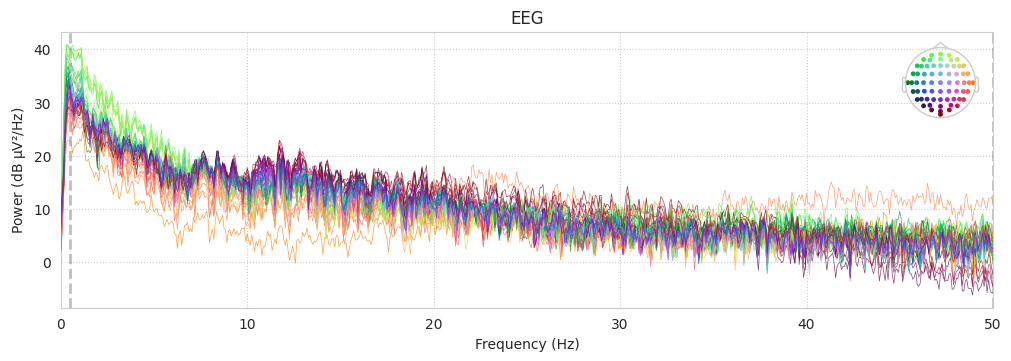

In [19]:
eeg_raw_list[1][3].plot_psd(fmax=50.0)

In [20]:
# Рассчитываем разницу между данными до и после фильтрации
diff = data_mean_filtered - data_mean

In [21]:
# Строим топографию разницы
fig, ax = plt.subplots(figsize=(8, 8))
mne.viz.plot_topomap(
    diff.mean(axis=0),  # Разница между фильтрованными и не фильтрованными данными
    pos,  # Позиции каналов
    ch_type="eeg",
    cmap="RdBu_r",
    contours=6,
    res=256,
    size=8,
    axes=ax,
    show=True,
)
plt.title("Difference Between Before and After Filtering")
plt.show()

<IPython.core.display.Javascript object>

# Графики для изучения данных

## Графики сигналов рана в разрезе ивентов

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

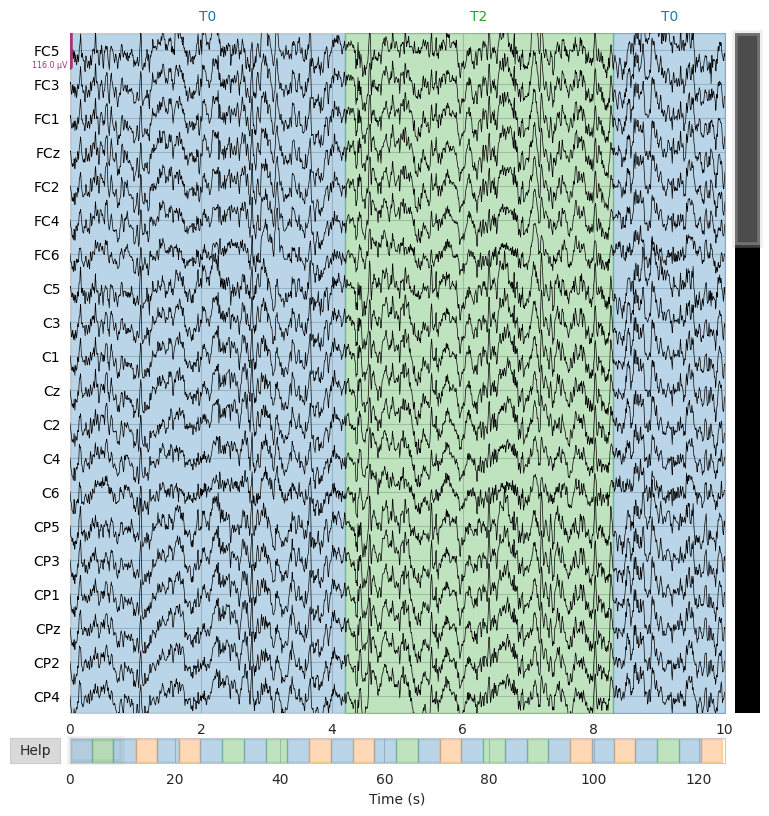

In [22]:
eeg_raw_list[1][3].plot(scalings="auto", show=False, block=False)

In [23]:
save_dir = cache_dir / "signal_plots"
save_dir.mkdir(parents=True, exist_ok=True)

for subject_idx, runs_dict in eeg_raw_list.items():
    for run_idx, raw in runs_dict.items():
        filename = save_dir / f"subject_{subject_idx}_run_{run_idx}.png"

        # Создание фигуры
        fig = raw.plot(
            scalings="auto",
            show=False,
            block=False,
            title=f"Subject {subject_idx}, Run {run_idx}",
        )

        fig.savefig(filename)
        plt.close(fig)

<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


<IPython.core.display.Javascript object>

Channels marked as bad:
none
Channels marked as bad:
none


## Топография в разрезе эпох (до декомпозиции)

In [24]:
# save_dir = cache_dir / Path("topographies_2/before_decomposition/by_each_epochs/")
# save_dir.mkdir(parents=True, exist_ok=True)
#
# for subject_idx, runs_dict in eeg_raw_list.items():
#     for run_idx, raw in runs_dict.items():
#         annotations = raw.annotations
#
#         events, event_id = mne.events_from_annotations(raw)
#
#         tmin, tmax = -0.5, 1.5
#         epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=(None, 0), preload=True)
#
#         for event_name, event_code in event_id.items():
#             event_epochs = epochs[event_name]
#
#             for epoch_idx, epoch_data in enumerate(event_epochs.get_data(), start=1):
#                 data_mean = epoch_data.mean(axis=1)
#
#                 pos = np.array([ch["loc"][:2] for ch in event_epochs.info["chs"]])
#
#                 filename = save_dir / f"topography_subject-{subject_idx}_run-{run_idx}_event-{event_name}_epoch-{epoch_idx}.png"
#
#                 if filename.exists():
#                     print(f"File {filename} already exists. Skipping...")
#                     continue
#
#                 fig, ax = plt.subplots(figsize=(8, 8))
#                 mne.viz.plot_topomap(
#                     data_mean,
#                     pos,
#                     ch_type="eeg",
#                     names=event_epochs.ch_names,
#                     sensors=True,
#                     cmap="RdBu_r",
#                     contours=6,
#                     res=256,
#                     size=8,
#                     axes=ax,
#                     show=False,
#                 )
#
#                 plt.savefig(filename)
#                 plt.close("all")
#
#                 del fig, ax, data_mean, pos
#                 gc.collect()

# Тензороризация и декомпозиция

# константы

In [25]:
tmin_global = 0.0
tmax_global = 4.0
baseline_global = (0.0, 0.0)

## Преобразование в тензор

In [26]:
total_epochs = 0

for subject_idx, runs_dict in eeg_raw_list.items():
    for run_idx, raw in runs_dict.items():
        events, event_id = mne.events_from_annotations(raw)

        tmin, tmax = tmin_global, tmax_global
        epochs = mne.Epochs(
            raw,
            events,
            event_id,
            tmin,
            tmax,
            baseline=baseline_global,
            preload=True,
        )

        num_epochs = len(epochs)
        print(
            f"Subject {subject_idx}, Run {run_idx}: {num_epochs} epochs",
            end="\n\n",
        )

        total_epochs += num_epochs

print(f"Общее количество эпох: {total_epochs}")

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Subject 1, Run 3: 30 epochs

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Subject 1, Run 4: 30 epochs

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Subject 1, Run 5: 30 epochs

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline corr

In [27]:
all_subjects = list(eeg_raw_list.keys())
all_runs = list(next(iter(eeg_raw_list.values())).keys())
first_raw = next(iter(next(iter(eeg_raw_list.values())).values()))

n_channels = len(first_raw.info["ch_names"])
sfreq = first_raw.info["sfreq"]

events, event_id = mne.events_from_annotations(first_raw)

tmin, tmax = tmin_global, tmax_global
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline_global, preload=True)

n_times = epochs.get_data().shape[2]

event_types = sorted(
    {event for runs in eeg_raw_list.values() for raw in runs.values() for event in raw.annotations.description}
)
n_events = len(event_types)

eeg_data_tensor = []

event_to_index = {event: idx for idx, event in enumerate(event_types)}

for subject_idx, runs_dict in eeg_raw_list.items():
    subject_data = []

    for run_idx, raw in runs_dict.items():
        events, event_id = mne.events_from_annotations(raw)

        tmin, tmax = tmin_global, tmax_global
        epochs = mne.Epochs(
            raw,
            events,
            event_id,
            tmin,
            tmax,
            baseline=baseline_global,
            preload=True,
        )

        run_data = np.zeros((n_events, len(epochs), n_channels, n_times))

        for event_name, event_code in event_id.items():
            if event_name in event_types:
                event_idx = event_to_index[event_name]
                event_epochs = epochs[event_name].get_data()

                run_data[event_idx, : event_epochs.shape[0], :, :] = event_epochs

        subject_data.append(run_data)

    eeg_data_tensor.append(subject_data)

eeg_data_tensor = np.array(eeg_data_tensor, dtype=np.float64)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 e

In [28]:
# (subject, run, event, epoch, channel, time)
print("Формат данных:", eeg_data_tensor.shape)

Формат данных: (3, 12, 3, 30, 64, 641)


## Сжатие декомпозицией (tucker)

In [29]:
torch.cuda.empty_cache()

gc.collect()

89078

In [30]:
rank = [
    eeg_data_tensor.shape[0],
    eeg_data_tensor.shape[1],
    eeg_data_tensor.shape[2],
    15,  # eeg_data_tensor.shape[3] // 2, 14
    eeg_data_tensor.shape[4],
    eeg_data_tensor.shape[5],
]

In [31]:
with tl.backend_context("pytorch"):
    tensor = tl.tensor(eeg_data_tensor).to("cuda")

    weight, factors = tl.decomposition.tucker(tensor, rank=rank, svd="truncated_svd", init="random", random_state=42)

    reconstructed_tensor = tl.tucker_to_tensor((weight, factors))

    frobenius_error = 100.0 * (tl.norm(reconstructed_tensor - tensor) / tl.norm(tensor)).item()

    original_size = IMetricCalculator.get_tensors_size(tensor)
    compressed_size = IMetricCalculator.get_tensors_size(weight, *factors)

    compression_ratio = 100.0 * compressed_size / original_size

print(f"Compression ratio: {compression_ratio}")
print(f"Frobenius error: {frobenius_error}")

del tensor, weight, factors

torch.cuda.empty_cache()

gc.collect()

Compression ratio: 50.3126662682248
Frobenius error: 4.366303702457285e-11


966

In [32]:
# (subject, run, event, epoch, channel, time)
print("Формат данных:", reconstructed_tensor.shape)

Формат данных: torch.Size([3, 12, 3, 30, 64, 641])


# Топография в разрезе эпох (после декомпозиции)

In [33]:
# save_dir = cache_dir / Path("topographies_2/after_decomposition/by_each_epochs/")
# save_dir.mkdir(parents=True, exist_ok=True)

In [34]:
# reconstructed_tensor = reconstructed_tensor.cpu().numpy().astype(np.float64)
#
# n_channels = 64
# sfreq = 160
# n_times = reconstructed_tensor.shape[-1]
#
# event_types = sorted({event for runs in eeg_raw_list.values() for raw in runs.values() for event in raw.annotations.description})
# n_events = len(event_types)
#
# event_to_index = {event: idx for idx, event in enumerate(event_types)}
#
# for subject_idx, subject_data in enumerate(reconstructed_tensor):
#     for run_idx, run_data in enumerate(subject_data):
#         for event_idx, event_name in enumerate(event_types):
#             event_epochs = run_data[event_idx]
#             for epoch_idx in range(event_epochs.shape[0]):
#                 if np.any(event_epochs[epoch_idx] != 0):
#                     data_mean = event_epochs[epoch_idx].mean(axis=1)
#
#                     pos = np.array([ch["loc"][:2] for ch in first_raw.info["chs"]])
#
#                     filename = save_dir / f"topography_subject-{subject_idx + 1}_run-{run_idx + 3}_event-{event_name}_epoch-{epoch_idx + 1}.png"
#
#                     if filename.exists():
#                         print(f"File {filename} already exists. Skipping...")
#                         continue
#
#                     fig, ax = plt.subplots(figsize=(8, 8))
#                     mne.viz.plot_topomap(
#                         data_mean,
#                         pos,
#                         ch_type="eeg",
#                         names=first_raw.info["ch_names"],
#                         sensors=True,
#                         cmap="RdBu_r",
#                         contours=6,
#                         res=256,
#                         size=8,
#                         axes=ax,
#                         show=False,
#                     )
#
#                     plt.savefig(filename)
#                     plt.close("all")
#
#                     del fig, ax, data_mean, pos
#                     gc.collect()

# Поиск оптимального ранга от frobenius error

## Параметры

In [35]:
eeg_data_tensor_16 = np.array(eeg_data_tensor, dtype=np.float16)
eeg_data_tensor_32 = np.array(eeg_data_tensor, dtype=np.float32)
eeg_data_tensor_64 = np.array(eeg_data_tensor, dtype=np.float64)

In [36]:
torch.cuda.empty_cache()

gc.collect()

2417

In [37]:
# compression_coefficients = [1, 2, 4, 8, 16]
#
# rank = [
#     eeg_data_tensor.shape[0],
#     eeg_data_tensor.shape[1],
#     eeg_data_tensor.shape[2],
#     eeg_data_tensor.shape[3],
#     eeg_data_tensor.shape[4],
#     eeg_data_tensor.shape[5],
# ]
#
# print(rank)

## Поиск - расчеты

In [38]:
# all_ranks = []
#
# for coeffs in itertools.product(compression_coefficients, repeat=len(rank)):
#     new_rank = [r // c for r, c in zip(rank, coeffs, strict=False)]
#     if new_rank not in all_ranks:
#         all_ranks.append(new_rank)

In [39]:
# min_frobenius_error = float("inf")
#
# tensor_compression_logs = []
#
# with tl.backend_context("pytorch"):
#     tensor = tl.tensor(eeg_data_tensor).to("cuda")
#
#     for index_rank, current_rank in enumerate(all_ranks):
#         try:
#             weight, factors = tl.decomposition.tucker(tensor, rank=current_rank, svd="truncated_svd", init="random",
#                                                       random_state=42)
#
#             reconstructed_tensor = tl.tucker_to_tensor((weight, factors))
#
#             frobenius_error = 100.0 * (tl.norm(reconstructed_tensor - tensor) / tl.norm(tensor)).item()
#
#             compression_ratio = 100.0 * IMetricCalculator.get_tensors_size(weight,
#                                                                            *factors) / IMetricCalculator.get_tensors_size(
#                 tensor)
#
#             tensor_compression_logs.append(
#                 {"rank": current_rank, "frobenius_error": frobenius_error, "compression_ratio": compression_ratio})
#
#             print(
#                 f"{index_rank} | frobenius error: {frobenius_error:.6f} % | compression ratio: {compression_ratio:.6f} % - {current_rank} / {rank}")
#
#             if frobenius_error < min_frobenius_error:
#                 min_frobenius_error = frobenius_error
#
#                 min_frob_compression_ratio = 100.0 * IMetricCalculator.get_tensors_size(weight,
#                                                                                         *factors) / IMetricCalculator.get_tensors_size(
#                     tensor)
#
#                 best_rank = current_rank
#
#             del weight, factors, reconstructed_tensor
#             torch.cuda.empty_cache()
#             gc.collect()
#
#         except Exception as e:
#             print(f"Error for rank {current_rank}: {e}")
#
#     del tensor
#     torch.cuda.empty_cache()
#     gc.collect()

In [40]:
# result_data = {
#     "tensor_compression_logs": tensor_compression_logs,
#     "best_rank": best_rank,
#     "min_frobenius_error": min_frobenius_error,
#     "min_frob_compression_ratio": min_frob_compression_ratio
# }
#
# with open(cache_dir / 'tensor_compression_results.json', 'w') as json_file:
#     json.dump(result_data, json_file, indent=4)

## Анализ результатов

In [41]:
# with open(cache_dir / 'tensor_compression_results.json', 'r') as json_file:
#     result_data = json.load(json_file)

In [42]:
# min_frobenius_error = result_data["min_frobenius_error"]
# min_frob_compression_ratio = result_data["min_frob_compression_ratio"]
# best_rank = result_data["best_rank"]
#
# print(f"Minimal Frobenius error, %: {min_frobenius_error:.6f} %")
# print(f"Compression ratio, %: {min_frob_compression_ratio:.6f} %")
# print(f"Best rank: {best_rank}")

In [43]:
# tensor_compression_logs = result_data["tensor_compression_logs"]
#
# sorted_logs = sorted(tensor_compression_logs, key=lambda x: x["frobenius_error"])
#
# for index_log, log in enumerate(sorted_logs):
#     print(f"{index_log} | {log['frobenius_error']:.6f} % | {log['compression_ratio']:.6f} % | {log['rank']}")

## Реализация автоматизированного алготритма для поиска оптимального ранга для такер декомпозиции

In [44]:
def find_optimal_rank_tucker_by_frobenius_error(
    tensor: np.array,
    tucker_args: dict,
    frobenius_error_limit: float = 1.0,
    search_strategy: str = "binary",
):
    """
    Finds the optimal rank for Tucker decomposition to ensure the Frobenius error does not exceed the specified limit.
    Supports binary and incremental search.

    :param tensor: Input tensor (np.array or torch.Tensor).
    :param tucker_args: Arguments for Tucker decomposition (e.g., SVD method).
    :param frobenius_error_limit: Frobenius error limit (%) between 1 and 100.
    :param search_strategy: Search strategy ("binary" or "incremental").
    :return: Optimal rank, minimum Frobenius error, compression ratio, and iteration logs.
    """
    import gc

    import tensorly as tl
    import torch

    from src.utils.metrics_calculators import IMetricCalculator

    if search_strategy not in ["binary", "incremental"]:
        raise ValueError("Invalid search strategy. Use 'binary' or 'incremental'.")  # noqa: EM101

    tensor_compression_logs = []
    tensor_shape = tensor.shape
    current_rank = list(tensor_shape)
    search_index = -1
    previous_best_error = float("inf")

    print("Optimal rank search process:")
    print("iteration number | rank | frobenius error (%) | compression ratio (%)")

    with tl.backend_context("pytorch"):
        tensor_cuda = tl.tensor(tensor).to("cuda")

        while True:
            candidates = []
            best_rank = None
            best_error, prev_frobenius_error = float("inf"), float("inf")
            best_compression = None

            for dim in range(len(tensor_shape)):
                if current_rank[dim] > 1:
                    if search_strategy == "binary":
                        low, high = 1, current_rank[dim]
                        mid = (low + high) // 2
                        candidates.append((dim, mid))
                        candidates.append((dim, current_rank[dim] - 1))

                    if search_strategy == "incremental":
                        candidates.append((dim, current_rank[dim] - 1))

            candidates = list(set(candidates))

            next_iteration_errors = []
            for dim, rank_value in candidates:
                test_rank = current_rank.copy()
                test_rank[dim] = rank_value

                try:
                    weight, factors = tl.decomposition.tucker(tensor_cuda, rank=test_rank, **tucker_args)
                    reconstructed_tensor = tl.tucker_to_tensor((weight, factors))
                    frobenius_error = (
                        100.0 * (tl.norm(reconstructed_tensor - tensor_cuda) / tl.norm(tensor_cuda)).item()
                    )
                    compression_ratio = (
                        100.0
                        * IMetricCalculator.get_tensors_size(weight, *factors)
                        / IMetricCalculator.get_tensors_size(tensor_cuda)
                    )

                    next_iteration_errors.append(frobenius_error)

                    if frobenius_error < prev_frobenius_error and frobenius_error <= frobenius_error_limit:
                        best_rank = test_rank.copy()
                        best_error = frobenius_error
                        best_compression = compression_ratio
                        prev_frobenius_error = frobenius_error

                    del weight, factors, reconstructed_tensor
                except Exception as e:
                    print(f"Error for rank {test_rank}: {e}")
                finally:
                    torch.cuda.empty_cache()
                    gc.collect()

            if (
                all(error > frobenius_error_limit for error in next_iteration_errors)
                and previous_best_error <= frobenius_error_limit
            ):
                print("Stopping: no further improvements possible or all next iterations exceed the error limit.")
                break

            current_rank = best_rank
            previous_best_error = best_error
            search_index += 1
            tensor_compression_logs.append(
                {
                    "rank": current_rank.copy(),
                    "frobenius_error": best_error,
                    "compression_ratio": best_compression,
                }
            )
            print(f"{search_index} | {current_rank} | {best_error:.6f} % | {best_compression:.6f} %")

    return current_rank, previous_best_error, tensor_compression_logs

## Применение функции

### Параметры

In [45]:
tucker_args = {
    "svd": "truncated_svd",
    "init": "random",
    "random_state": 42,
}

In [76]:
eeg_data_tensor_32.shape

(3, 12, 3, 30, 64, 641)

### 32 бита тензор

In [49]:
optimal_rank_32_1, frobenius_error_32_1, logs_32_1 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_32,
    tucker_args=tucker_args,
    frobenius_error_limit=1.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 15, 64, 641] | 0.020075 % | 50.312666 %
1 | [3, 12, 3, 15, 64, 640] | 0.020056 % | 50.234181 %
2 | [3, 12, 3, 15, 64, 639] | 0.314922 % | 50.155696 %
3 | [3, 12, 3, 15, 64, 638] | 0.448106 % | 50.077210 %
4 | [3, 12, 3, 15, 64, 637] | 0.550937 % | 49.998725 %
5 | [3, 12, 3, 15, 64, 636] | 0.638248 % | 49.920239 %
6 | [3, 12, 3, 15, 64, 635] | 0.716019 % | 49.841754 %
7 | [3, 12, 3, 15, 64, 634] | 0.786491 % | 49.763269 %
8 | [3, 12, 3, 15, 64, 633] | 0.851866 % | 49.684783 %
9 | [3, 12, 3, 15, 64, 632] | 0.913582 % | 49.606298 %
10 | [3, 12, 3, 15, 64, 631] | 0.971763 % | 49.527813 %
Stopping: no further improvements possible or all next iterations exceed the error limit.


In [51]:
print(list(eeg_data_tensor_32.shape), optimal_rank_32_1, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 631]


In [52]:
optimal_rank_32_2, frobenius_error_32_2, logs_32_2 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_32,
    tucker_args=tucker_args,
    frobenius_error_limit=2.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 15, 64, 641] | 0.020075 % | 50.312666 %
1 | [3, 12, 3, 15, 64, 640] | 0.020056 % | 50.234181 %
2 | [3, 12, 3, 15, 64, 639] | 0.314922 % | 50.155696 %
3 | [3, 12, 3, 15, 64, 638] | 0.448106 % | 50.077210 %
4 | [3, 12, 3, 15, 64, 637] | 0.550937 % | 49.998725 %
5 | [3, 12, 3, 15, 64, 636] | 0.638248 % | 49.920239 %
6 | [3, 12, 3, 15, 64, 635] | 0.716019 % | 49.841754 %
7 | [3, 12, 3, 15, 64, 634] | 0.786491 % | 49.763269 %
8 | [3, 12, 3, 15, 64, 633] | 0.851866 % | 49.684783 %
9 | [3, 12, 3, 15, 64, 632] | 0.913582 % | 49.606298 %
10 | [3, 12, 3, 15, 64, 631] | 0.971763 % | 49.527813 %
11 | [3, 12, 3, 15, 64, 630] | 1.028098 % | 49.449327 %
12 | [3, 12, 3, 15, 64, 629] | 1.081820 % | 49.370842 %
13 | [3, 12, 3, 15, 64, 628] | 1.133219 % | 49.292356 %
14 | [3, 12, 3, 15, 64, 627] | 1.182469 % | 49.213871 %
15 | [3, 12, 3, 15, 64, 626] | 1.230348 % | 49.135386 %
16 | [3, 12, 3,

In [53]:
print(list(eeg_data_tensor_32.shape), optimal_rank_32_2, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 606]


In [54]:
optimal_rank_32_5, frobenius_error_32_5, logs_32_5 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_32,
    tucker_args=tucker_args,
    frobenius_error_limit=5.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 15, 64, 641] | 0.020075 % | 50.312666 %
1 | [3, 12, 3, 15, 64, 640] | 0.020056 % | 50.234181 %
2 | [3, 12, 3, 15, 64, 639] | 0.314922 % | 50.155696 %
3 | [3, 12, 3, 15, 64, 638] | 0.448106 % | 50.077210 %
4 | [3, 12, 3, 15, 64, 637] | 0.550937 % | 49.998725 %
5 | [3, 12, 3, 15, 64, 636] | 0.638248 % | 49.920239 %
6 | [3, 12, 3, 15, 64, 635] | 0.716019 % | 49.841754 %
7 | [3, 12, 3, 15, 64, 634] | 0.786491 % | 49.763269 %
8 | [3, 12, 3, 15, 64, 633] | 0.851866 % | 49.684783 %
9 | [3, 12, 3, 15, 64, 632] | 0.913582 % | 49.606298 %
10 | [3, 12, 3, 15, 64, 631] | 0.971763 % | 49.527813 %
11 | [3, 12, 3, 15, 64, 630] | 1.028098 % | 49.449327 %
12 | [3, 12, 3, 15, 64, 629] | 1.081820 % | 49.370842 %
13 | [3, 12, 3, 15, 64, 628] | 1.133219 % | 49.292356 %
14 | [3, 12, 3, 15, 64, 627] | 1.182469 % | 49.213871 %
15 | [3, 12, 3, 15, 64, 626] | 1.230348 % | 49.135386 %
16 | [3, 12, 3,

In [55]:
print(list(eeg_data_tensor_32.shape), optimal_rank_32_5, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 491]


### 64 бит тензор

In [56]:
optimal_rank_64_1, frobenius_error_64_1, logs_64_1 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_64,
    tucker_args=tucker_args,
    frobenius_error_limit=1.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 30, 64, 640] | 0.000000 % | 100.156516 %
1 | [3, 12, 3, 29, 64, 640] | 0.000000 % | 96.828361 %
2 | [3, 12, 3, 15, 64, 640] | 0.000000 % | 50.234181 %
3 | [3, 12, 3, 15, 64, 639] | 0.314298 % | 50.155696 %
4 | [3, 12, 3, 15, 64, 638] | 0.447655 % | 50.077210 %
5 | [3, 12, 3, 15, 64, 637] | 0.550575 % | 49.998725 %
6 | [3, 12, 3, 15, 64, 636] | 0.637931 % | 49.920239 %
7 | [3, 12, 3, 15, 64, 635] | 0.715739 % | 49.841754 %
8 | [3, 12, 3, 15, 64, 634] | 0.786234 % | 49.763269 %
9 | [3, 12, 3, 15, 64, 633] | 0.851635 % | 49.684783 %
10 | [3, 12, 3, 15, 64, 632] | 0.913366 % | 49.606298 %
11 | [3, 12, 3, 15, 64, 631] | 0.971555 % | 49.527813 %
Stopping: no further improvements possible or all next iterations exceed the error limit.


In [57]:
print(list(eeg_data_tensor_64.shape), optimal_rank_64_1, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 631]


In [58]:
optimal_rank_64_2, frobenius_error_64_2, logs_64_2 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_64,
    tucker_args=tucker_args,
    frobenius_error_limit=2.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 30, 64, 640] | 0.000000 % | 100.156516 %
1 | [3, 12, 3, 29, 64, 640] | 0.000000 % | 96.828361 %
2 | [3, 12, 3, 15, 64, 640] | 0.000000 % | 50.234181 %
3 | [3, 12, 3, 15, 64, 639] | 0.314298 % | 50.155696 %
4 | [3, 12, 3, 15, 64, 638] | 0.447655 % | 50.077210 %
5 | [3, 12, 3, 15, 64, 637] | 0.550575 % | 49.998725 %
6 | [3, 12, 3, 15, 64, 636] | 0.637931 % | 49.920239 %
7 | [3, 12, 3, 15, 64, 635] | 0.715739 % | 49.841754 %
8 | [3, 12, 3, 15, 64, 634] | 0.786234 % | 49.763269 %
9 | [3, 12, 3, 15, 64, 633] | 0.851635 % | 49.684783 %
10 | [3, 12, 3, 15, 64, 632] | 0.913366 % | 49.606298 %
11 | [3, 12, 3, 15, 64, 631] | 0.971555 % | 49.527813 %
12 | [3, 12, 3, 15, 64, 630] | 1.027903 % | 49.449327 %
13 | [3, 12, 3, 15, 64, 629] | 1.081638 % | 49.370842 %
14 | [3, 12, 3, 15, 64, 628] | 1.133042 % | 49.292356 %
15 | [3, 12, 3, 15, 64, 627] | 1.182303 % | 49.213871 %
16 | [3, 12, 3

In [59]:
print(list(eeg_data_tensor_64.shape), optimal_rank_64_2, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 606]


In [60]:
optimal_rank_64_5, frobenius_error_64_5, logs_64_5 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_64,
    tucker_args=tucker_args,
    frobenius_error_limit=5.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 3, 30, 64, 640] | 0.000000 % | 100.156516 %
1 | [3, 12, 3, 29, 64, 640] | 0.000000 % | 96.828361 %
2 | [3, 12, 3, 15, 64, 640] | 0.000000 % | 50.234181 %
3 | [3, 12, 3, 15, 64, 639] | 0.314298 % | 50.155696 %
4 | [3, 12, 3, 15, 64, 638] | 0.447655 % | 50.077210 %
5 | [3, 12, 3, 15, 64, 637] | 0.550575 % | 49.998725 %
6 | [3, 12, 3, 15, 64, 636] | 0.637931 % | 49.920239 %
7 | [3, 12, 3, 15, 64, 635] | 0.715739 % | 49.841754 %
8 | [3, 12, 3, 15, 64, 634] | 0.786234 % | 49.763269 %
9 | [3, 12, 3, 15, 64, 633] | 0.851635 % | 49.684783 %
10 | [3, 12, 3, 15, 64, 632] | 0.913366 % | 49.606298 %
11 | [3, 12, 3, 15, 64, 631] | 0.971555 % | 49.527813 %
12 | [3, 12, 3, 15, 64, 630] | 1.027903 % | 49.449327 %
13 | [3, 12, 3, 15, 64, 629] | 1.081638 % | 49.370842 %
14 | [3, 12, 3, 15, 64, 628] | 1.133042 % | 49.292356 %
15 | [3, 12, 3, 15, 64, 627] | 1.182303 % | 49.213871 %
16 | [3, 12, 3

In [61]:
print(list(eeg_data_tensor_64.shape), optimal_rank_64_5, sep="\n")

[3, 12, 3, 30, 64, 641]
[3, 12, 3, 15, 64, 491]


# Альтернативный тензор

In [62]:
all_subjects = list(eeg_raw_list.keys())
all_runs = list(next(iter(eeg_raw_list.values())).keys())
first_raw = next(iter(next(iter(eeg_raw_list.values())).values()))

n_channels = len(first_raw.info["ch_names"])
sfreq = first_raw.info["sfreq"]

desired_annotations = ["T1", "T2"]  # without 'T0'

events, event_id = mne.events_from_annotations(first_raw)

tmin, tmax = -4.0, 4.0
baseline = (0.0, 0.0)

filtered_event_id = {key: value for key, value in event_id.items() if key in desired_annotations}

epochs = mne.Epochs(
    first_raw,
    events,
    filtered_event_id,
    tmin,
    tmax,
    baseline=baseline,
    preload=True,
)

n_times = epochs.get_data().shape[2]

event_types = sorted(desired_annotations)
n_events = len(event_types)

eeg_data_tensor_alter = []
event_to_index = {event: idx for idx, event in enumerate(event_types)}

total_epochs = 0

for subject_idx, runs_dict in eeg_raw_list.items():
    subject_data = []

    for run_idx, raw in runs_dict.items():
        events, event_id = mne.events_from_annotations(raw)

        filtered_event_id = {key: value for key, value in event_id.items() if key in desired_annotations}

        if not filtered_event_id:
            print(f"Subject {subject_idx}, Run {run_idx}: No desired annotations found")
            continue

        epochs = mne.Epochs(
            raw,
            events,
            filtered_event_id,
            tmin,
            tmax,
            baseline=baseline,
            preload=True,
        )

        num_epochs = len(epochs)
        total_epochs += num_epochs
        print(
            f"Subject {subject_idx}, Run {run_idx}: {num_epochs} epochs for {list(filtered_event_id.keys())}",
            end="\n\n",
        )

        run_data = np.zeros((n_events, len(epochs), n_channels, n_times))

        for event_name, event_code in filtered_event_id.items():
            if event_name in event_types:
                event_idx = event_to_index[event_name]
                event_epochs = epochs[event_name].get_data()

                run_data[event_idx, : event_epochs.shape[0], :, :] = event_epochs

        subject_data.append(run_data)

    eeg_data_tensor_alter.append(subject_data)

eeg_data_tensor_alter = np.array(eeg_data_tensor_alter, dtype=np.float64)

print(f"Total epochs count: {total_epochs}")

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 1281 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 1281 original time points ...
0 bad epochs dropped
Subject 1, Run 3: 15 epochs for ['T1', 'T2']

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 1281 original time points ...
0 bad epochs dropped
Subject 1, Run 4: 15 epochs for ['T1', 'T2']

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Applying basel

In [63]:
eeg_data_tensor_alter_16 = np.array(eeg_data_tensor_alter, dtype=np.float16)
eeg_data_tensor_alter_32 = np.array(eeg_data_tensor_alter, dtype=np.float32)
eeg_data_tensor_alter_64 = np.array(eeg_data_tensor_alter, dtype=np.float64)

## Применение метода поиска оптимального ранга

### 32 бита тензор

In [64]:
optimal_rank_32_1, frobenius_error_32_1, logs_32_1 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_32,
    tucker_args=tucker_args,
    frobenius_error_limit=1.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 15, 64, 1280] | 0.037317 % | 101.778845 %
1 | [3, 12, 2, 14, 64, 1280] | 0.037030 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.037597 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.037416 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.037776 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.037321 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.037329 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.037609 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.160158 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.223913 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.273998 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.316529 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.354274 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.388637 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.420442 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.450542 % | 54.803843 %
16 | [3,

In [65]:
print(list(eeg_data_tensor_alter_32.shape), optimal_rank_32_1, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 1245]


In [66]:
optimal_rank_32_2, frobenius_error_32_2, logs_32_2 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_32,
    tucker_args=tucker_args,
    frobenius_error_limit=2.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 15, 64, 1280] | 0.037317 % | 101.778845 %
1 | [3, 12, 2, 14, 64, 1280] | 0.037030 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.037597 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.037416 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.037776 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.037321 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.037329 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.037609 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.160158 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.223913 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.273998 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.316529 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.354274 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.388637 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.420442 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.450542 % | 54.803843 %
16 | [3,

In [67]:
print(list(eeg_data_tensor_alter_32.shape), optimal_rank_32_2, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 1163]


In [68]:
optimal_rank_32_5, frobenius_error_32_5, logs_32_5 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_32,
    tucker_args=tucker_args,
    frobenius_error_limit=5.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 15, 64, 1280] | 0.037317 % | 101.778845 %
1 | [3, 12, 2, 14, 64, 1280] | 0.037030 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.037597 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.037416 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.037776 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.037321 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.037329 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.037609 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.160158 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.223913 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.273998 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.316529 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.354274 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.388637 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.420442 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.450542 % | 54.803843 %
16 | [3,

In [69]:
print(list(eeg_data_tensor_alter_32.shape), optimal_rank_32_5, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 862]


### 64 бита тензор

In [70]:
optimal_rank_64_1, frobenius_error_64_1, logs_64_1 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_64,
    tucker_args=tucker_args,
    frobenius_error_limit=1.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 14, 64, 1281] | 0.000000 % | 95.191672 %
1 | [3, 12, 2, 14, 64, 1280] | 0.000000 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.000000 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.000000 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.000000 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.000000 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.000000 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.000000 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.155712 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.220721 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.271428 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.314281 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.352249 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.386797 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.418771 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.448974 % | 54.803843 %
16 | [3, 

In [71]:
print(list(eeg_data_tensor_alter_64.shape), optimal_rank_64_1, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 1245]


In [72]:
optimal_rank_64_2, frobenius_error_64_2, logs_64_2 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_64,
    tucker_args=tucker_args,
    frobenius_error_limit=2.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 14, 64, 1281] | 0.000000 % | 95.191672 %
1 | [3, 12, 2, 14, 64, 1280] | 0.000000 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.000000 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.000000 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.000000 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.000000 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.000000 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.000000 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.155712 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.220721 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.271428 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.314281 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.352249 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.386797 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.418771 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.448974 % | 54.803843 %
16 | [3, 

In [73]:
print(list(eeg_data_tensor_alter_64.shape), optimal_rank_64_2, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 1163]


In [74]:
optimal_rank_64_5, frobenius_error_64_5, logs_64_5 = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_data_tensor_alter_64,
    tucker_args=tucker_args,
    frobenius_error_limit=5.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 12, 2, 14, 64, 1281] | 0.000000 % | 95.191672 %
1 | [3, 12, 2, 14, 64, 1280] | 0.000000 % | 95.117366 %
2 | [3, 12, 2, 13, 64, 1280] | 0.000000 % | 88.455887 %
3 | [3, 12, 2, 12, 64, 1280] | 0.000000 % | 81.794407 %
4 | [3, 12, 2, 11, 64, 1280] | 0.000000 % | 75.132928 %
5 | [3, 12, 2, 10, 64, 1280] | 0.000000 % | 68.471449 %
6 | [3, 12, 2, 9, 64, 1280] | 0.000000 % | 61.809969 %
7 | [3, 12, 2, 8, 64, 1280] | 0.000000 % | 55.148490 %
8 | [3, 12, 2, 8, 64, 1279] | 0.155712 % | 55.105409 %
9 | [3, 12, 2, 8, 64, 1278] | 0.220721 % | 55.062328 %
10 | [3, 12, 2, 8, 64, 1277] | 0.271428 % | 55.019247 %
11 | [3, 12, 2, 8, 64, 1276] | 0.314281 % | 54.976166 %
12 | [3, 12, 2, 8, 64, 1275] | 0.352249 % | 54.933085 %
13 | [3, 12, 2, 8, 64, 1274] | 0.386797 % | 54.890005 %
14 | [3, 12, 2, 8, 64, 1273] | 0.418771 % | 54.846924 %
15 | [3, 12, 2, 8, 64, 1272] | 0.448974 % | 54.803843 %
16 | [3, 

In [75]:
print(list(eeg_data_tensor_alter_64.shape), optimal_rank_64_5, sep="\n")

[3, 12, 2, 15, 64, 1281]
[3, 12, 2, 8, 64, 862]


# Обработка второго датасета EEG

In [46]:
limo_raw_list = {}

subjects = list(range(2, 5))

for subject in subjects:
    limo_raw_list[subject] = {}

for subject in subjects:
    epochs = mne.datasets.limo.load_data(path=cache_dir, subject=subject)

    limo_raw_list[subject] = epochs

<IPython.core.display.Javascript object>

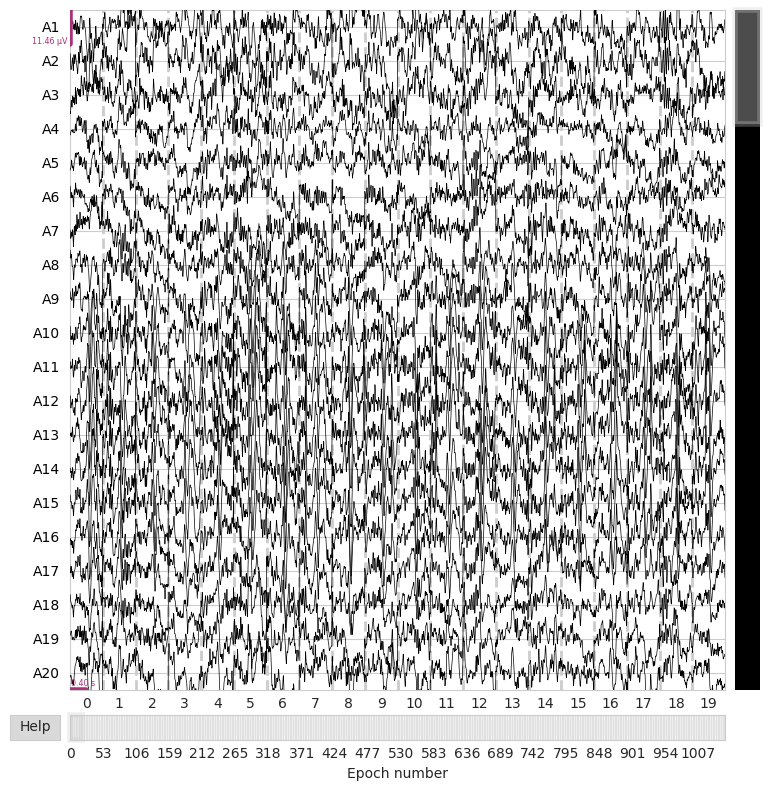

In [47]:
epochs.plot(scalings="auto", show=False, block=False)

In [73]:
n_channels = len(limo_raw_list[2].info["ch_names"])


eeg_limo_data_tensor = []


# Список типов событий
event_types = sorted({event for epochs in limo_raw_list.values() for event in epochs.event_id})

# Маппинг событий
event_to_index = {event: idx for idx, event in enumerate(event_types)}

# Определим минимальное количество эпох
min_epochs = min(len(epochs.get_data()) for epochs in limo_raw_list.values())

for subject_idx, epochs in limo_raw_list.items():
    subject_data = []

    # Получаем все эпохи
    epoch_objs = epochs.get_data()

    # Обрезаем или дополняем эпохи, чтобы все их количество совпадало
    epoch_objs = epoch_objs[:min_epochs]  # Убираем лишние эпохи

    n_times = epoch_objs.shape[2]

    run_data = np.zeros((len(epoch_objs), len(event_types), n_channels, n_times))  # Один run, все эпохи

    # Заполняем тензор для каждого события
    for event_name, event_code in epochs.event_id.items():
        if event_name in event_types:
            event_idx = event_to_index[event_name]

            # Проходим по всем эпохам
            for epoch_idx, epoch_data in enumerate(epoch_objs):
                event_epochs = epoch_data  # Для упрощения, просто берем данные всех эпох для каждого события
                run_data[epoch_idx, event_idx, :, :] = event_epochs

    subject_data.append(run_data)
    eeg_limo_data_tensor.append(subject_data)

# Преобразуем в numpy массив
eeg_limo_data_tensor = np.array(eeg_limo_data_tensor, dtype=np.float32)

In [74]:
# (subject, run, epochs, event, channel, time)
eeg_limo_data_tensor.shape

(3, 1, 1050, 2, 132, 201)

In [75]:
(
    optimal_rank_second_eeg_32_1,
    frobenius_error_second_eeg_32_1,
    logs_second_eeg_32_1,
) = find_optimal_rank_tucker_by_frobenius_error(
    tensor=eeg_limo_data_tensor,
    tucker_args=tucker_args,
    frobenius_error_limit=1.0,
    search_strategy="binary",
)

Optimal rank search process:
iteration number | rank | frobenius error (%) | compression ratio (%)
0 | [3, 1, 1050, 2, 132, 200] | 0.054416 % | 100.196551 %
1 | [3, 1, 1050, 1, 132, 200] | 0.054131 % | 50.445306 %
2 | [3, 1, 1050, 1, 132, 199] | 0.054918 % | 50.196429 %
3 | [3, 1, 1050, 1, 131, 199] | 0.055076 % | 49.821332 %
4 | [3, 1, 1050, 1, 131, 198] | 0.054356 % | 49.574340 %
5 | [3, 1, 1050, 1, 131, 197] | 0.054302 % | 49.327348 %
6 | [3, 1, 1050, 1, 131, 196] | 0.054681 % | 49.080356 %
7 | [3, 1, 1050, 1, 131, 195] | 0.054838 % | 48.833364 %
8 | [3, 1, 1050, 1, 131, 194] | 0.054832 % | 48.586372 %
9 | [3, 1, 1050, 1, 131, 193] | 0.055115 % | 48.339380 %
10 | [3, 1, 1050, 1, 131, 192] | 0.054451 % | 48.092388 %
11 | [3, 1, 1050, 1, 131, 191] | 0.054388 % | 47.845396 %
12 | [3, 1, 1050, 1, 131, 190] | 0.054261 % | 47.598404 %
13 | [3, 1, 1050, 1, 131, 189] | 0.054818 % | 47.351412 %
14 | [3, 1, 1050, 1, 131, 188] | 0.054092 % | 47.104420 %
15 | [3, 1, 1050, 1, 131, 187] | 0.05495